In [ ]:
from google.colab import drive
drive.mount('/content/drive')
userpath='/content/drive/MyDrive/CUAI'

Mounted at /content/drive


## 4.3 앙상블 학습 개요

여러 개의 분류기 생성, 예측 결합 = 집단지성
- 비정형 데이터 분류 - 딥러닝이 good
- 대부분의 정형 데이터 분류 - 앙상블이 good


앙상블 알고리즘의 대표
- Random Forest
- Gradient Boosting, XGBoost, LightGBM, Stacking, ...

앙상블 학습의 유형
- Voting: 서로 다른 알고리즘을 가진 분류기가 동일한 data set을 가지고 학습, 투표를 통해 최종 예측 결과를 결정
  - Hard Voting: 다수결
  - Soft Voting: 분류기들이 구한 각 label 값 결정 확률의 평균을 구하고, 확률이 가장 높은 label을 최종 결과로 예측.
- Bagging: 같은 유형의 알고리즘을 기반으로 한 분류기가 다른 sampling data set를 가져가서(Bootstrapping, 교차검증과 다르게 각 set에는 중복된 데이터가 있을 수 있음) 학습, 투표를 통해 최종 예측 결과 결정. (ex- Random Forest)
- Boosting: 여러 개의 분류기가 순차적으로 학습 수행, 먼저 학습한 분류기가 예측이 틀린 데이터에 대해선 다음 분류기에서 가중치를 부여해서 학습 및 예측. (ex- Gradient Boost, XGBoost, LightGBM) 
- Stacking: 다른 모델의 예측 결과값을 다시 학습 데이터로 만들어서 메타 모델로 재학습시켜 결과 예측



### Voting Classifier

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' ) #voting의 기본값은 'hard'

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


Voting으로 여러 개 분류기 결합한다고 해서 무조건 성능이 향상되는 건 x. 그러나 높은 유연성을 가지고 있기에 현실 데이터에서 단일 알고리즘보다 뛰어난 성능을 보일 확률이 높음.

## 4.4 Random Forest

- 앙상블 알고리즘 중 비교적 빠른 수행 속도
- 다양한 영역에서 높은 예측 성능
- 기반 알고리즘: 결정 트리 => 쉽고 직관적인 장점 유지!
- 개별 트리가 학습하는 데이터는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트. (Bootstrapping; Bagging이 bootstrap aggregating의 줄임말.)
- n_estimators: hyperparameter
- sklearn의 RandomForestClassifier class를 사용할 예정.

트리 기반 앙상블 알고리즘의 단점: hyperparameter가 너무 많아서 튜닝을 위한 시간이 많이 소모됨. 심지어 많은 시간을 소모했음에도 튜닝 후 예측 성능이 크게 향상되는 경우가 많지 않음

RF의 Hyperparameter
- n_estimators: 결정 트리의 개수. 기본값 10, 클수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 무조건 좋아지진 않음. 늘릴수록 학습 수행 시간 늘어남.
- max_features: 기본값 'auto' (cf. 결정 트리에서 max_features 기본값은 'None')
- 나머진 결정 트리랑 동일

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [ ]:
import pandas as pd
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(userpath+'/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(userpath+'/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(userpath+'/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(userpath+'/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(userpath+'/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


**GridSearchCV**로 하이퍼 파라미터 튜닝.
- 사용자가 모델의 하이퍼 파라미터 값을 리스트로 입력하면 값에 대한 경우의 수마다 예측 성능을 측정·평가하여 최적의 하이퍼 파라미터 값을 찾아줌
- 시간이 오래 걸림
- n_jobs=-1로 할 경우 모든 코어를 사용, 기본값 1
- cv=(교차검증을 위한 fold 횟수). k-fold를 사용하고 싶을 경우 cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=36) 이런 식으로 해주면 됨
- model_name.bestparams: 최적의 파라미터 값 반환
- model_name.bestscore: 예측 정확도 반환

책에선 튜닝 시간을 줄이기 위해 n_estimators=100, cv=2로만 설정했다고 함


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


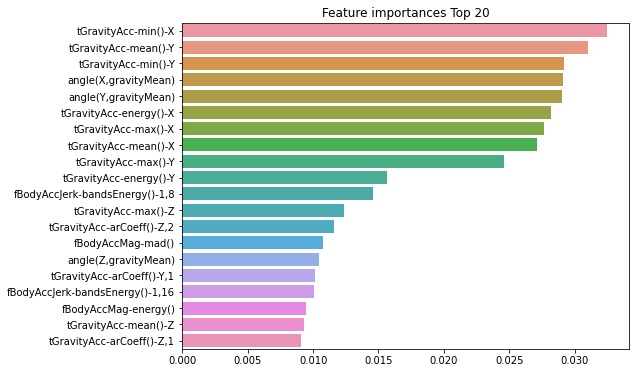

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('rf_feature_importances_top20.tif', format='tif', dpi=300, bbox_inches='tight')

## 4.5 GBM(Gradient Boosting Machine)

### Boosting
- 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치를 부여해 오류를 개선하면서 학습
- AdaBoost(Adaptive boosting)
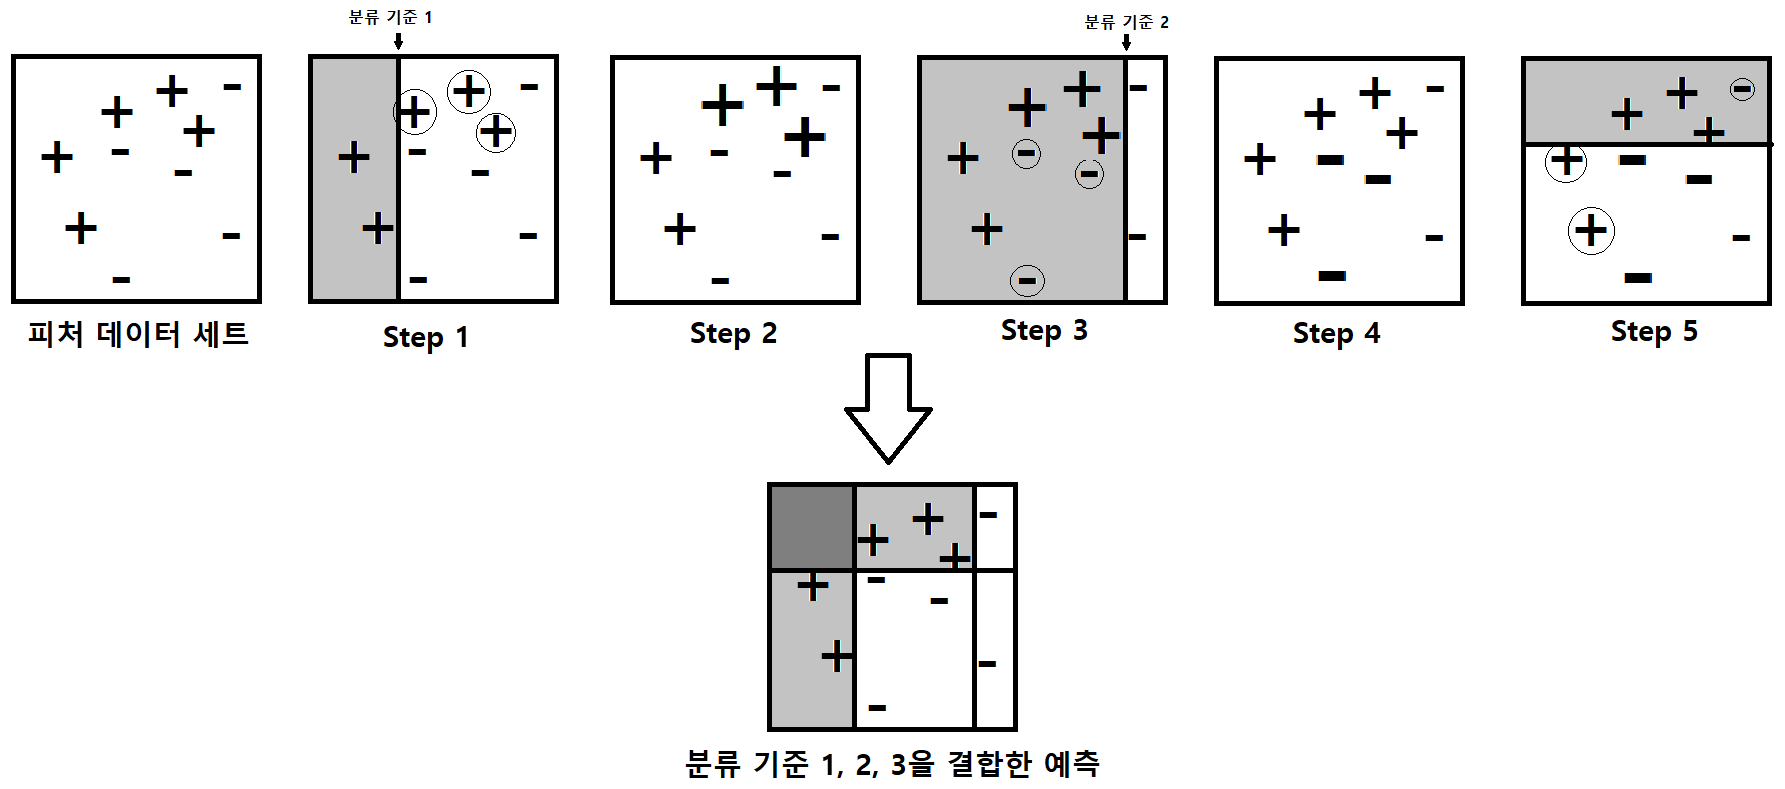
  - 동그라미로 표시된 게 잘못 분류된 데이터. 여기에 가중치를 부여해 다음 학습기에선 더 잘 분류할 수 있게 해줌
  - 이렇게 학습한 학습기들을 결합한 결과 예측을 내면 개별 weak learner보다 높은 정확도를 낼 수 있음
- Gradient Boost (GBM)
  - 가중치 업데이트에 경사 하강법(Gradient Descent)를 이용한다는 점에서 Adaboost와 차이가 있음. (경사 하강법은 회귀에서 자세히 다룸)
  - sklearn의 GradientBoostingClassifier class를 이용하겠음
  - 일반적으로 RF보다 예측 성능이 조금 뛰어나지만, 수행 시간이 오래 걸리고 하이퍼 파라미터 튜닝에도 노력이 더 필요함. (찾아보니 사이킷런이 업그레이드 되면서 GBM 수행 시간이 너무 오래 걸리게 돼서 웬만하면 사이킷런에선 GBM을 안 쓰는 게 좋다는 의견도 있음. 뒷부분인 XGBoost, LightGBM을 소개하기 위해 이론적으로만 다루는 듯듯)
  - loss: 경사하강법에 적용할 비용 함수, 기본값 'deviance'
  - learning_rate: 경사하강법에 적용할 학습률, 0~1까지 지정 가능하고 기본값은 0.1. 너무 작으면 수행 시간이 오래 걸리고 너무 크면 예측 성능이 떨어질 가능성 높아짐 → n_estimators와 조합해 사용. (예- learning_rate 작게, n_estimators 크게... 그러나 이 역시 수행 시간이 오래 걸리고 성능이 크게 좋아지진 않는다고 함)
  - n_estimators: weak learner의 개수, 기본값 100
  - subsample: 데이터 샘플링 비율, 기본값은 1이지만 0.5~1 사이의 값을 사용하는 편.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))


GBM 정확도: 0.9386
GBM 수행 시간: 1003.4 초 


In [ ]:
### 아래는 책에서 설명드리지는 않지만 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝을 수행하는 예제 입니다. 
### 사이킷런이 1.X로 업그레이드 되며서 GBM의 학습 속도가 현저하게 저하되는 문제가 오히려 발생합니다. 
### 아래는 수행 시간이 오래 걸리므로 참고용으로만 사용하시면 좋을 것 같습니다. 

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9002


In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9393
